In [17]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-community-1')

diarization = pipeline('cocktail_party_sample.wav')

for turn, speaker in diarization.speaker_diarization:
    print(f"{speaker} speaks between t={turn.start:.4f}s and t={turn.end:.4f}s")

/home/emiliopicard/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1762089971981/work/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


SPEAKER_00 speaks between t=6.7303s and t=6.7472s
SPEAKER_01 speaks between t=6.7472s and t=7.0341s
SPEAKER_00 speaks between t=7.0341s and t=7.1860s
SPEAKER_00 speaks between t=7.5910s and t=7.6078s
SPEAKER_01 speaks between t=7.6078s and t=8.3166s
SPEAKER_00 speaks between t=8.3166s and t=9.9197s
SPEAKER_01 speaks between t=9.9197s and t=10.9828s
SPEAKER_00 speaks between t=10.4597s and t=14.7460s
SPEAKER_01 speaks between t=14.3072s and t=17.8847s
SPEAKER_00 speaks between t=18.0197s and t=21.5128s
SPEAKER_01 speaks between t=18.1547s and t=18.4416s
SPEAKER_01 speaks between t=21.7660s and t=28.4991s
SPEAKER_00 speaks between t=27.8578s and t=29.9672s


In [39]:
import numpy as np
import librosa
SAMPLE_RATE = 48000

segments = []
y, sr = librosa.load('cocktail_party_sample.wav', sr=SAMPLE_RATE)
audio_data = np.ascontiguousarray(y)
print(len(audio_data))
n_samples = len(audio_data)
overlap_mask = np.zeros(n_samples, dtype=np.float32)
for turn, speaker in diarization.speaker_diarization:
    segments.append({
        "start": turn.start,
        "end": turn.end,
        "speaker": speaker
    })
print(segments)
for i, seg_i in enumerate(segments):
    # only overlaps involving target speaker
    if seg_i["speaker"] != 'SPEAKER_00':
        continue

    for j, seg_j in enumerate(segments):
        if i!=j:
            # intersection
            overlap_start = max(seg_i["start"], seg_j["start"])
            overlap_end = min(seg_i["end"], seg_j["end"])

            if overlap_start >= overlap_end:
                continue  # no overlap
            else:
                print("overlap detected")
                # time → samples
                start_sample = int(overlap_start * SAMPLE_RATE)
                end_sample = int(overlap_end * SAMPLE_RATE)
                print(end_sample)

                start_sample = max(0, start_sample)
                end_sample = min(n_samples, end_sample)
                print(f"overlap between {start_sample / SAMPLE_RATE} and {end_sample / SAMPLE_RATE}")
                overlap_mask[start_sample:end_sample] = 1.0

1440000
[{'start': 6.730343750000001, 'end': 6.74721875, 'speaker': 'SPEAKER_00'}, {'start': 6.74721875, 'end': 7.03409375, 'speaker': 'SPEAKER_01'}, {'start': 7.03409375, 'end': 7.185968750000001, 'speaker': 'SPEAKER_00'}, {'start': 7.59096875, 'end': 7.607843750000001, 'speaker': 'SPEAKER_00'}, {'start': 7.607843750000001, 'end': 8.316593750000003, 'speaker': 'SPEAKER_01'}, {'start': 8.316593750000003, 'end': 9.919718750000001, 'speaker': 'SPEAKER_00'}, {'start': 9.919718750000001, 'end': 10.98284375, 'speaker': 'SPEAKER_01'}, {'start': 10.45971875, 'end': 14.745968750000003, 'speaker': 'SPEAKER_00'}, {'start': 14.30721875, 'end': 17.88471875, 'speaker': 'SPEAKER_01'}, {'start': 18.01971875, 'end': 21.512843750000002, 'speaker': 'SPEAKER_00'}, {'start': 18.15471875, 'end': 18.44159375, 'speaker': 'SPEAKER_01'}, {'start': 21.765968750000003, 'end': 28.49909375, 'speaker': 'SPEAKER_01'}, {'start': 27.85784375, 'end': 29.96721875, 'speaker': 'SPEAKER_00'}]
overlap detected
527176
overla

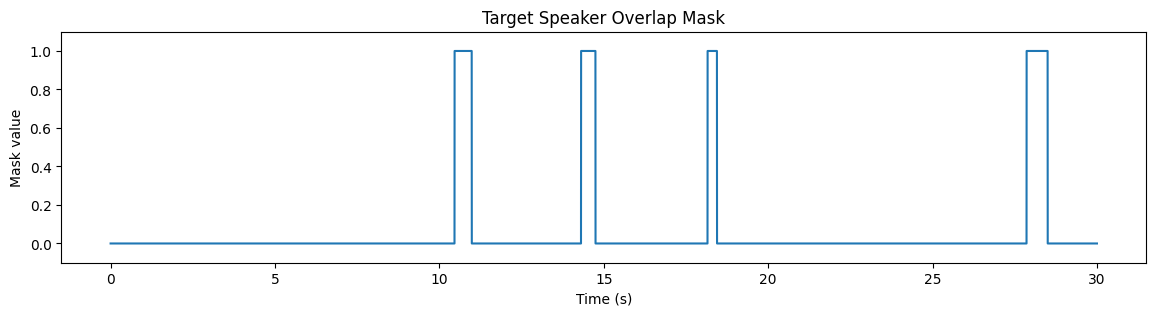

In [40]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(len(overlap_mask)) / sr  # time axis in seconds

plt.figure(figsize=(14, 3))
plt.plot(t, overlap_mask)
plt.xlabel("Time (s)")
plt.ylabel("Mask value")
plt.title("Target Speaker Overlap Mask")
plt.ylim(-0.1, 1.1)
plt.show()

480000


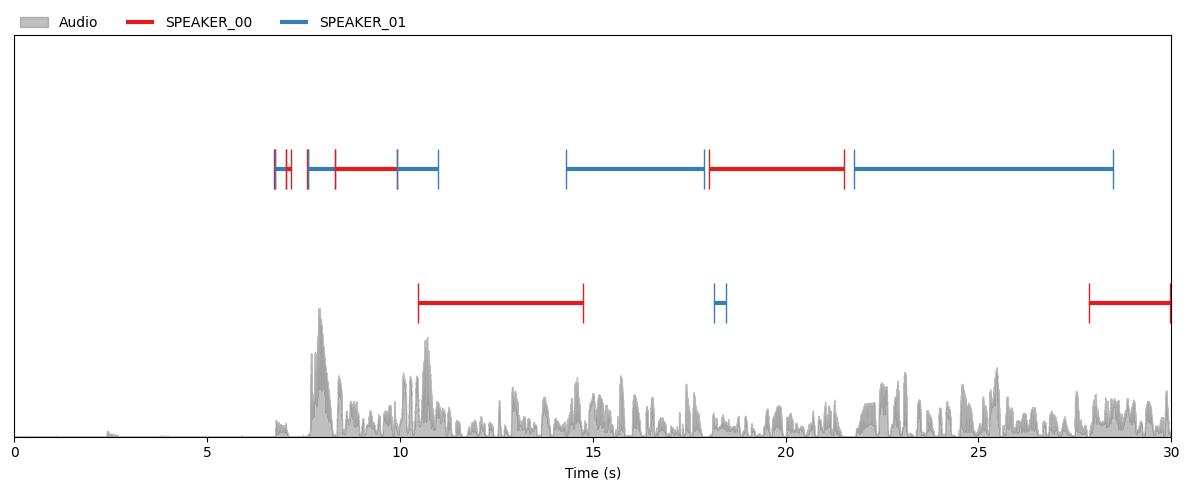

In [26]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pyannote.core import Segment, notebook

audio_path = 'cocktail_party_sample.wav'

annotation = diarization.speaker_diarization
y, sr = librosa.load(audio_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
notebook.crop = Segment(0, duration)

fig, ax = plt.subplots(figsize=(12, 5))

librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.5, color="gray", label="Audio")
notebook.plot_annotation(annotation, ax=ax, time=True, legend=True)

ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

Found 4!
Overlap detected from 10.5s to 11.0s
Overlap detected from 14.3s to 14.7s
Overlap detected from 18.2s to 18.4s
Overlap detected from 27.9s to 28.5s


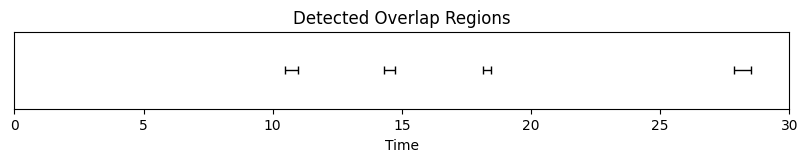

In [ ]:
overlaps = annotation.get_overlap() # pyannote.core.annotation
print(f"Found {len(overlaps)}!")
for segment in overlaps:
    print(f"Overlap detected from {segment.start:.1f}s to {segment.end:.1f}s")

plt.figure(figsize=(10, 1))
notebook.plot_timeline(overlaps, time=True)
plt.title("Detected Overlap Regions")
plt.show()